In [1]:
import pandas as pd
from presentation import *

%matplotlib inline

# MelaNet
## Skin cancer classification
###### Robin Ali - Louise Badarani - Cyriac Parisot - Clément Ponsonnet - Ruoy Zhang

On average between 2 and 3 million skin cancers are diagnosed yearly world wide (World Health Organization). AI has been proven as a powerful diagnostic tool in medical fiels. We thus aim to develop a classifier to help dermathologist assess their diagnostics and understand the most prominent characteristics of each cancer types.

## 1. Introduction: the DATA
The data consists of 10 015 images accompanied by additional information regarding the patients.

In [2]:
label_dir = '../skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
image_dir = '../skin-cancer-mnist-ham10000/data/'

In [3]:
labels = pd.read_csv(label_dir)
labels.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


###### Variable description
* **lesion_id** : ID of lesions
* **image_id** : ID of picture
* **dx** : type of cancer
* **dx_type** : method used for diagnosis
* **age** :  age of patient
* **sex** : sex of patient
* **localization** : localization of the tumor

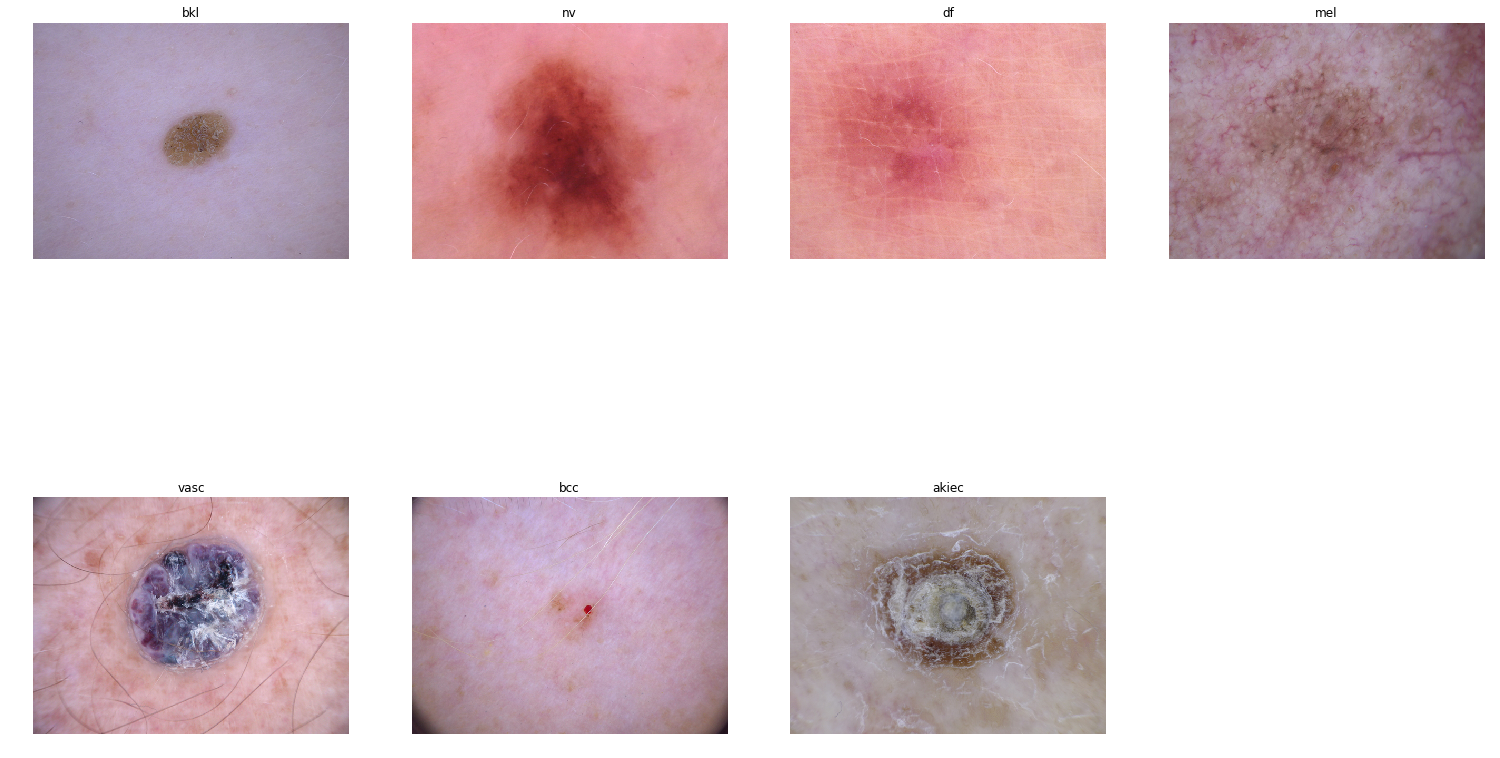

In [7]:
cancer_types = list(labels.dx.unique())
images = select_images(labels)
plot_images(image_dir, images, cancer_types)